In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [202]:
import scipy
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_mixture_batches
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_hmm, train_hmm_subjects
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from models.HMM.HMM_torch import HiddenMarkovModel as HMM
from data.synthetic_generator import syntheticHMM
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib
import matplotlib as mpl
import scipy
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

def set_color_cycle(self, clist=None):
    if clist is None:
        clist = rcParams['axes.color_cycle']
    self.color_cycle = itertools.cycle(clist)

# Loading LEiDA

In [3]:
fmri_dataset = '../data/dataset/dataset_all_subjects_LEiDA.hdf5'
dataf = h5py.File(fmri_dataset, mode='r')

num_subjects = len(list(dataf.keys()))
seq_len = 330
obs_dim = 90

leida_full = torch.zeros(num_subjects,seq_len,obs_dim)

for idx, subject in enumerate(list(dataf.keys())):
    leida_full[idx] = torch.tensor(np.array(dataf[subject]))
    
print(leida_full.shape)

torch.Size([199, 330, 90])


# Batching all subject for HMM

In [143]:
leida_train_raw = leida_full[:,:int(seq_len/2),:]
leida_test_raw = leida_full[:,int(seq_len/2):,:]

torch.Size([199, 165, 90])

In [178]:
## Random shuffled batches of 15-20
leida_train = TensorDataset(leida_train_raw)
train_loader = DataLoader(leida_train, batch_size=20, shuffle=True)

leida_test = TensorDataset(leida_test_raw)
test_loader = DataLoader(leida_test, batch_size=20, shuffle = False)

## HMM v2 training and test - loop

In [193]:
def hmm_train_and_eval(model, train_dataloader, test_dataloader, optimizer, num_epoch):
    
    model = model.to(device)
    
    train_results = np.zeros(num_epoch)
    test_results = np.zeros(num_epoch)

    for epoch in tqdm(range(num_epoch), leave=False, desc='Epoch'):
    
        # Tranining model
        running_train = 0
        model.train(True)
        for idx, data in enumerate(tqdm(train_dataloader,leave=False, desc="Train")):
            
            batch_leida_vectors = data[0].to(device)
            
            
            optimizer.zero_grad()
            
            NegativeLogLikelihood = - model(batch_leida_vectors)
            
            NegativeLogLikelihood.backward()
            optimizer.step()
            
            
            running_train += NegativeLogLikelihood

        train_results[epoch] = running_train

        
        #Test/Evaluation
        running_test = 0
        model.eval()
        with torch.no_grad():
            for idx, data in enumerate(tqdm(test_dataloader,leave=False, desc="Test")):
                test_leida_vectors = data[0].to(device)
                test_NegativeLogLikelihood = -model(test_leida_vectors)
                
                running_test += test_NegativeLogLikelihood
                
            test_results[epoch] = running_test
        
    return train_results, test_results

# Hidden Markov Model - Watson

In [188]:
lr_eval = np.arange(0.08, 1, 0.12)[:3]
print(lr_eval)

[0.08 0.2  0.32]


## Watson Learning rate

In [199]:
epochs = 3
train_lr_results = np.zeros((len(lr_eval), epochs))
test_lr_results = np.zeros((len(lr_eval), epochs))

for idx, lr in enumerate(tqdm(lr_eval)):
    
    model = HMM(num_states=8, emission_dist=Watson) #New init of model
    adam = optim.Adam(model.parameters(), lr=lr)
    
    train_res, test_res = hmm_train_and_eval(model, train_loader, test_loader, optimizer=adam, num_epoch=epochs)
    
    train_lr_results[idx] = train_res
    test_lr_results[idx] = test_res

    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

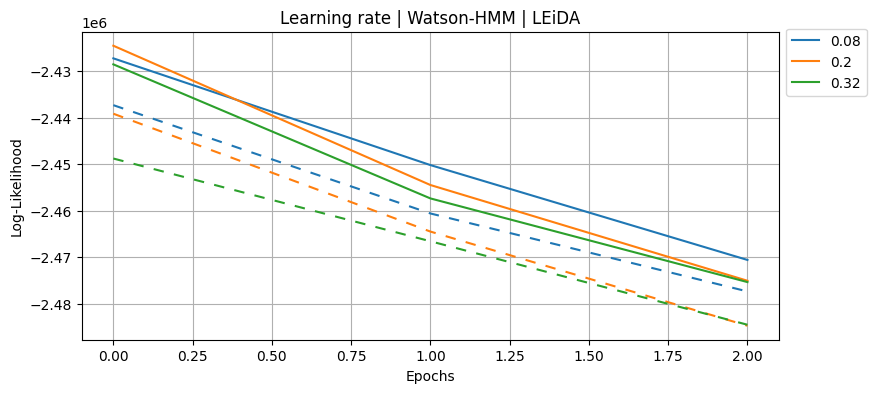

In [207]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(train_lr_results.T)
plt.gca().set_prop_cycle(None)
plt.plot(test_lr_results.T, linestyle=(0,(5,5)))
plt.title('Learning rate | Watson-HMM | LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(lr_eval, 3), ncol=1, bbox_to_anchor=(1.01, 1.01), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

# State eval

In [ ]:
state_eval =

In [ ]:
int_epoch = 125
runs = 5
state_results = np.zeros((runs, len(state_eval),int_epoch))
LR = .65
best_like = -1e+5


for run_i in range(runs):
    for idx, states in enumerate(tqdm(state_eval)):

        model = HMM(num_states=8, observation_dim=90, emission_dist=Watson) #New init of model
        Adam_optimizer = optim.Adam(model.parameters(), lr=LR)
        model_like = train_hmm(model, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)

        state_results[run_i, idx] = model_like

        if model_like[-1] < best_like:
            best_model = Watson_model
            best_like = model_like[-1]
            best_idx = idx

In [111]:
res = state_results[0]

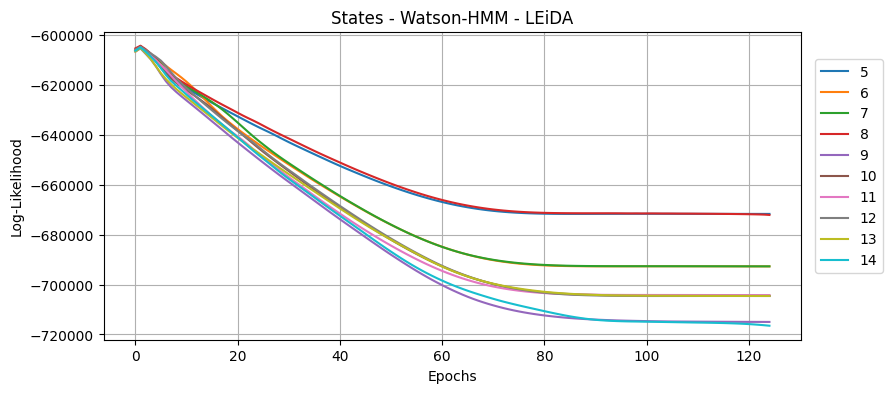

In [130]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(res.T)
plt.title('States - Watson-HMM - LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(cluster_eval, ncol=1, bbox_to_anchor=(1.02, .91), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [118]:
res.shape

(10, 125)

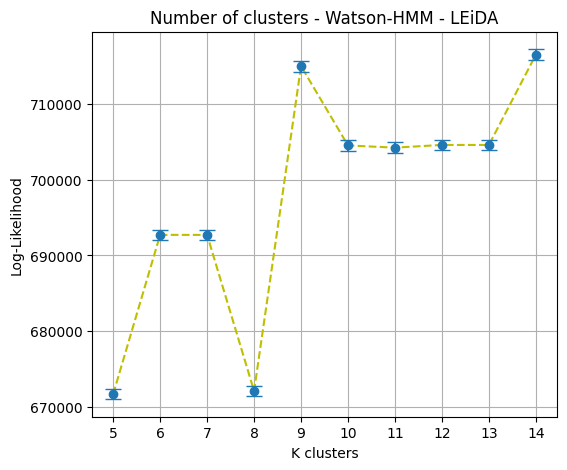

In [131]:

plt.close()
%matplotlib inline
plt.figure(figsize=(6, 5))

plt.plot(state_eval, -res[:,-1], '--y')
plt.errorbar(state_eval, -res[:,-1], yerr=res[:,-1]*.001, capsize=6,fmt='o', ls='none')
plt.title('Number of clusters - Watson-HMM - LEiDA')
plt.xlabel('K clusters')
plt.ylabel('Log-Likelihood')
plt.xticks([*cluster_eval])
#plt.legend(cluster_eval, ncol=2, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

## Train model with best lr

In [134]:
model_dist = Watson
WBmodel = HMM(num_states=9, observation_dim=90, emission_dist=model_dist)

#_ = get_param(WBmodel)

In [141]:
Adam_optimizer = optim.Adam(WBmodel.parameters(), lr=0.65)
wb_epoch_likelihood = train_hmm(WBmodel, data=leida_50_train, optimizer=Adam_optimizer, num_epoch=250, keep_bar=False)

  0%|          | 0/250 [00:00<?, ?it/s]

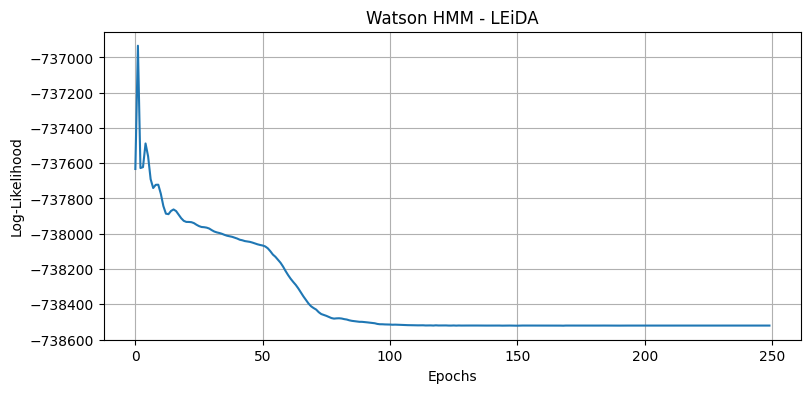

In [142]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(wb_epoch_likelihood)
plt.title('Watson HMM - LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()

In [104]:
print(wb_epoch_likelihood[-4:])

[3739.58496094 3740.51025391 3741.38745117 3742.02050781]


In [143]:
wb_param = get_param(WBmodel)

un_norm_priors
tensor([  0.2253,  -1.0399,   0.7621,  -0.4323,  -0.0450,  -1.4562,   0.9467,
         -0.3384, -22.3222])
------------------------------
un_norm_Transition_matrix
tensor([[ 8.2310,  4.0869,  3.6426,  3.5758,  4.2065,  3.8814,  3.3509,  3.8650,
          4.2294],
        [ 1.9838,  6.5202,  0.1758,  2.1208,  1.7809,  2.3145,  2.5214,  2.6246,
          1.8589],
        [ 2.1621,  0.5947,  6.6728,  2.6358,  2.3984,  3.0233,  2.7993,  2.6217,
          2.3813],
        [ 0.6247,  1.1218,  1.7690,  5.5951,  1.4433, -0.4873,  1.7092,  1.5834,
          0.7566],
        [ 3.6111,  3.0383,  3.8213,  3.8548,  7.7951,  3.4278,  2.7920,  3.5134,
          2.7974],
        [ 2.0050,  1.5858,  1.8806,  1.8755,  2.1151,  6.1166,  2.0954,  1.9809,
          1.2414],
        [ 1.3306,  1.3850,  1.7662,  1.3534,  1.9226,  1.5016,  6.1704,  1.8875,
          1.6201],
        [ 1.6704,  1.0068,  1.9440,  1.5995,  1.7827,  1.5915,  1.7254,  5.9373,
          1.6477],
        [ 2.9761,  2.

In [154]:
t = wb_param['un_norm_Transition_matrix']

In [196]:
t.softmax(dim=1)

tensor([[0.9051, 0.0144, 0.0092, 0.0086, 0.0162, 0.0117, 0.0069, 0.0115, 0.0166],
        [0.0098, 0.9120, 0.0016, 0.0112, 0.0080, 0.0136, 0.0167, 0.0185, 0.0086],
        [0.0098, 0.0020, 0.8907, 0.0157, 0.0124, 0.0232, 0.0185, 0.0155, 0.0122],
        [0.0063, 0.0103, 0.0197, 0.9052, 0.0142, 0.0021, 0.0186, 0.0164, 0.0072],
        [0.0138, 0.0078, 0.0171, 0.0176, 0.9074, 0.0115, 0.0061, 0.0125, 0.0061],
        [0.0147, 0.0097, 0.0130, 0.0129, 0.0164, 0.8962, 0.0161, 0.0143, 0.0068],
        [0.0073, 0.0077, 0.0113, 0.0075, 0.0132, 0.0087, 0.9220, 0.0127, 0.0097],
        [0.0126, 0.0065, 0.0166, 0.0118, 0.0141, 0.0117, 0.0133, 0.9010, 0.0124],
        [0.0106, 0.0071, 0.0086, 0.0107, 0.0113, 0.0063, 0.0152, 0.0229, 0.9074]])

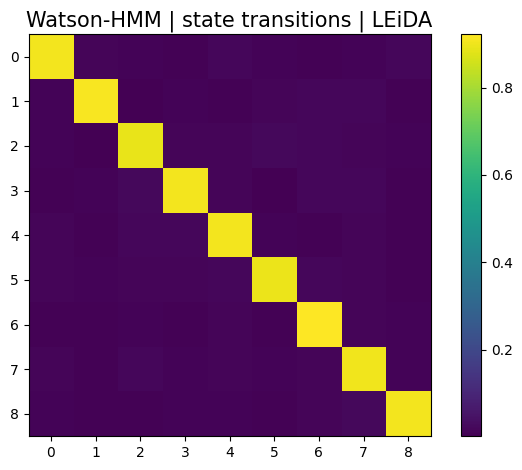

In [197]:
fig, ax = plt.subplots()
im = ax.imshow(t.softmax(dim=1))

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(farmers)), labels=farmers)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(vegetables)):
#     for j in range(len(farmers)):
#         text = ax.text(j, i, harvest[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Watson-HMM | state transitions | LEiDA", size=15)
fig.tight_layout()
plt.colorbar(im, ax=ax)
plt.show()

## Viterbi decode - Watson | LEiDA

### OBSERVE CLUSTER SWITCH

In [190]:
best_paths, paths_probs = WBmodel.viterbi2(leida_50_train[:5])

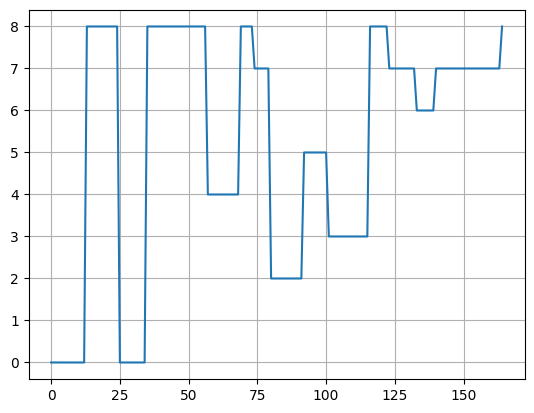

In [199]:
plt.close()
%matplotlib inline
plt.plot(best_paths[0])
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


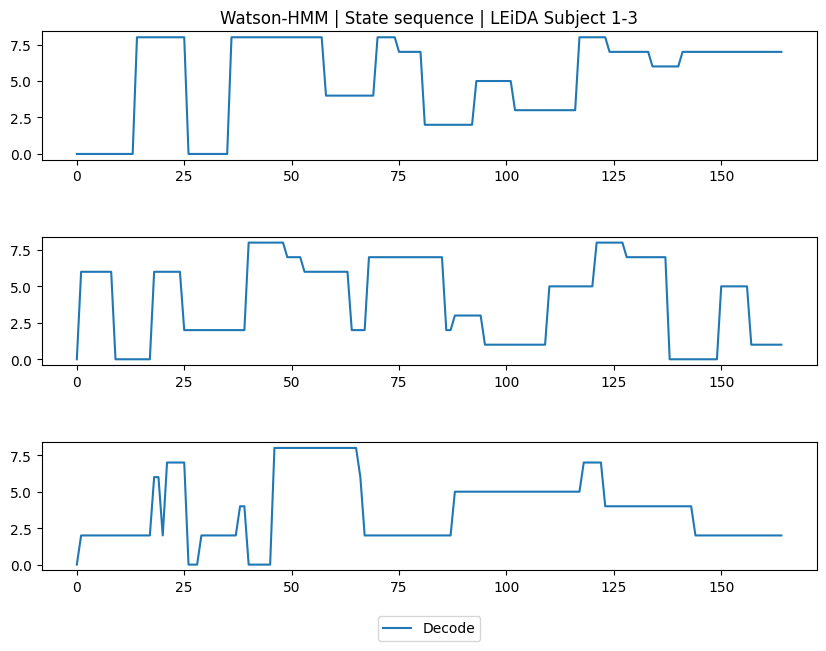

In [200]:
sub = 4
decode_path = list(best_paths[sub])
decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(3,1, figsize=(10,7))
fig.subplots_adjust(hspace=0.6)

for sub in range(3):
    decode_path = list(best_paths[sub])
    decode_path.insert(0,0) # shift correnction
    ax[sub].plot(decode_path[:-1], label='Decode')
    #ax[sub].yticks([0,1,2])
    ax[0].set_title('Watson-HMM | State sequence | LEiDA Subject 1-3')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
               ncol=2)

plt.show()

## Watson-HMM | NMI score

In [117]:
from sklearn.metrics import normalized_mutual_info_score as NMI

In [228]:
NMI(Z_seq[sub],decode_path[:-1])

0.5397459496727025

<IPython.core.display.Javascript object>


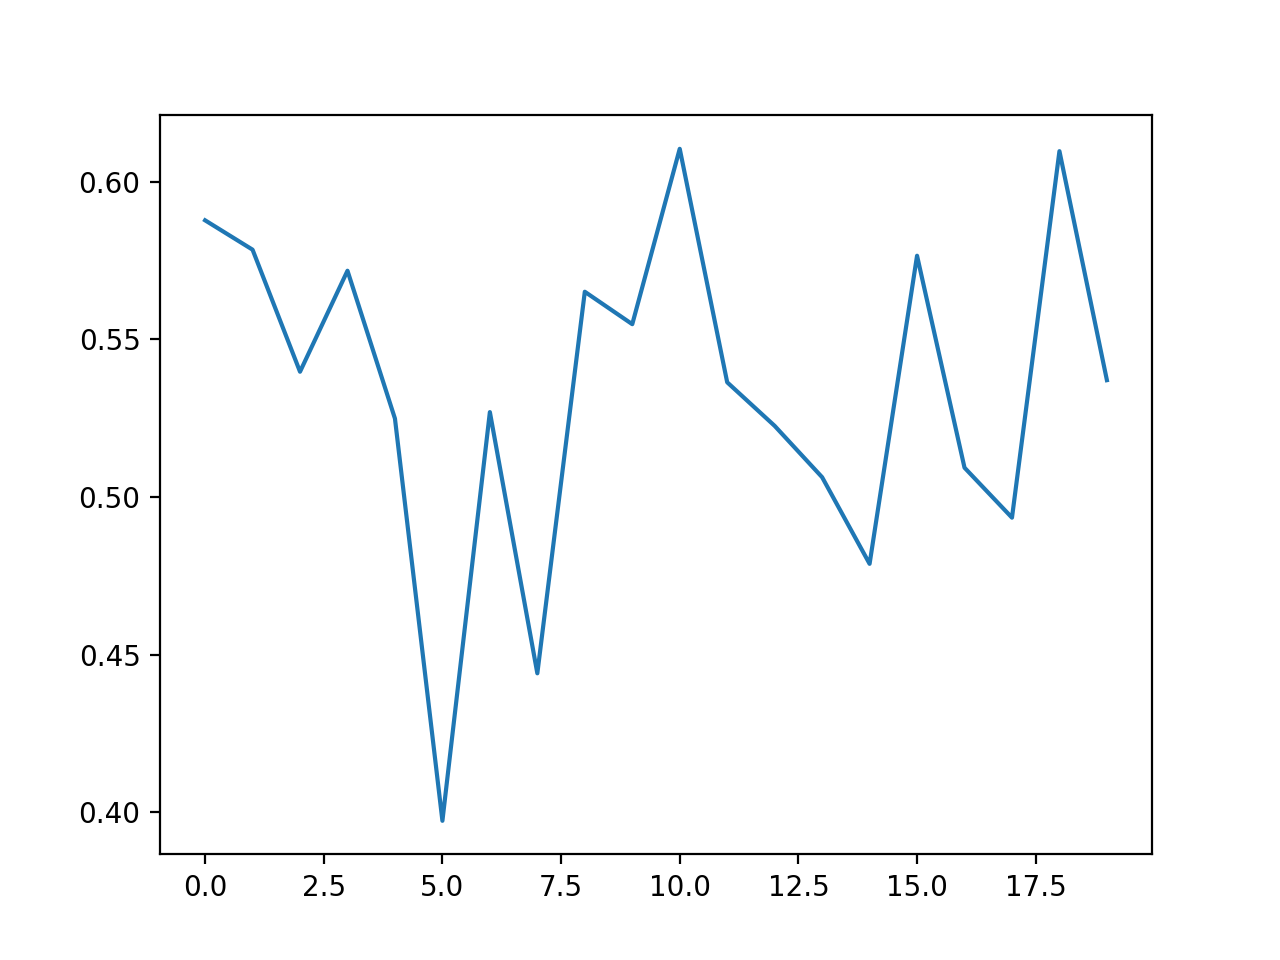

Average Watson NMI: 0.533576335840456


In [234]:
d = {'0':2,'2':0} 
running_NMI = []
for sub in range(len(best_paths)):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    
    gt = Z_seq[sub]
    
    sub_NMI = NMI(gt,decode_path[:-1])
    running_NMI.append(sub_NMI)
plt.close()
plt.plot(running_NMI)
plt.show()
print(f'Average Watson NMI: {np.mean(running_NMI)}')

# ACG-HMM | Synthetic3D

In [161]:
model_dist = ACG
model = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(model)

un_norm_priors
tensor([0.9173, 0.6097, 0.5565])
------------------------------
un_norm_Transition_matrix
tensor([[0.6103, 0.4260, 0.8132],
        [0.9944, 0.5229, 0.3641],
        [0.8209, 0.1309, 0.3439]])
------------------------------
emission_model_0
tensor([[ 0.6015,  0.3338, -0.0070],
        [ 0.3338,  0.8665,  0.8257],
        [-0.0070,  0.8257,  1.6651]])
------------------------------
emission_model_1
tensor([[ 0.8731, -0.3004, -0.7644],
        [-0.3004,  1.9117,  3.3430],
        [-0.7644,  3.3430,  6.6568]])
------------------------------
emission_model_2
tensor([[ 1.6294, -1.0954, -1.0589],
        [-1.0954,  1.8851,  1.7557],
        [-1.0589,  1.7557,  2.3355]])
------------------------------


In [193]:
hmm_eval_LR = np.arange(0.08, 1, 0.08)[4:5]
hmm_eval_LR = [0.35,0.45,0.55,0.65,0.7]
print(hmm_eval_LR)

[0.35, 0.45, 0.55, 0.65, 0.7]


In [194]:
int_epoch = 100
acg_hmm_LR_results = np.zeros((len(hmm_eval_LR),int_epoch))
best_like = 4000.
for idx, LR in enumerate(tqdm(hmm_eval_LR)):
    acg_hmm = HMM(num_states=3, observation_dim=3, emission_dist=model_dist) #New init of model
    Adam_optimizer = optim.Adam(acg_hmm.parameters(), lr=LR)
    likehood = train_hmm(acg_hmm, data=synX_emission, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)
    acg_hmm_LR_results[idx] = likehood
    
    if likehood[-1] < best_like:
        best_model = acg_hmm
        best_like = likehood[-1]
        best_idx = idx
        
    acg_hmm_LR_results[idx] = likehood

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [200]:
print(best_idx)
print(acg_hmm_LR_results[best_idx,-1])

1
2572.8603515625


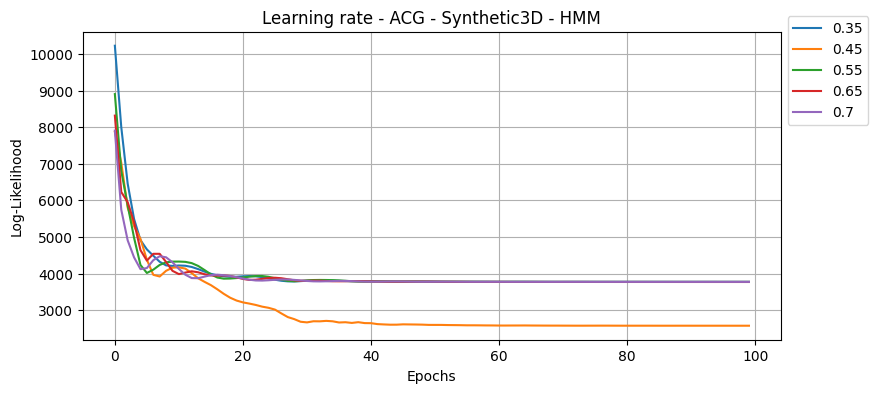

In [197]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(acg_hmm_LR_results.T)
plt.title('Learning rate - ACG - Synthetic3D - HMM')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(hmm_eval_LR, 3), ncol=1, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [201]:
acg_hmm_LR_results[:,-1]

array([3771.75195312, 2572.86035156, 3770.29101562, 3768.36914062,
       3770.71850586])

### Best lr ACG HMM train

In [202]:
acgbest_param = get_param(best_model)

un_norm_priors
tensor([ 2.1921, -5.4010,  1.3396])
------------------------------
un_norm_Transition_matrix
tensor([[0.3971, 0.4432, 0.2327],
        [0.2331, 0.6659, 0.1756],
        [0.5760, 0.4823, 0.4948]])
------------------------------
emission_model_0
tensor([[ 3.4026e+01,  3.8848e+00, -1.4942e-01],
        [ 3.8848e+00,  4.7790e-01, -1.7807e-02],
        [-1.4942e-01, -1.7807e-02,  3.8401e-02]])
------------------------------
emission_model_1
tensor([[0.0693, 0.0362, 0.1542],
        [0.0362, 0.0937, 0.2414],
        [0.1542, 0.2414, 1.1341]])
------------------------------
emission_model_2
tensor([[ 1.1644e-02,  1.7637e-04, -3.2642e-04],
        [ 1.7637e-04,  1.9032e+00,  3.8778e+00],
        [-3.2642e-04,  3.8778e+00,  1.7774e+01]])
------------------------------


In [208]:
learned_sigma = torch.stack([acgbest_param[f'emission_model_{idx}'] for idx in range(acgbest.N)])
learned_pi = acgbest_param['un_norm_priors'] + torch.tensor([0.,7.,0.])
learned_pi = scipy.special.softmax(np.array(learned_pi),0)
print(learned_pi)

[0.50531155 0.27924424 0.21544424]


### Syn vs Learned ACG on the sphere3d | From HMM

Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


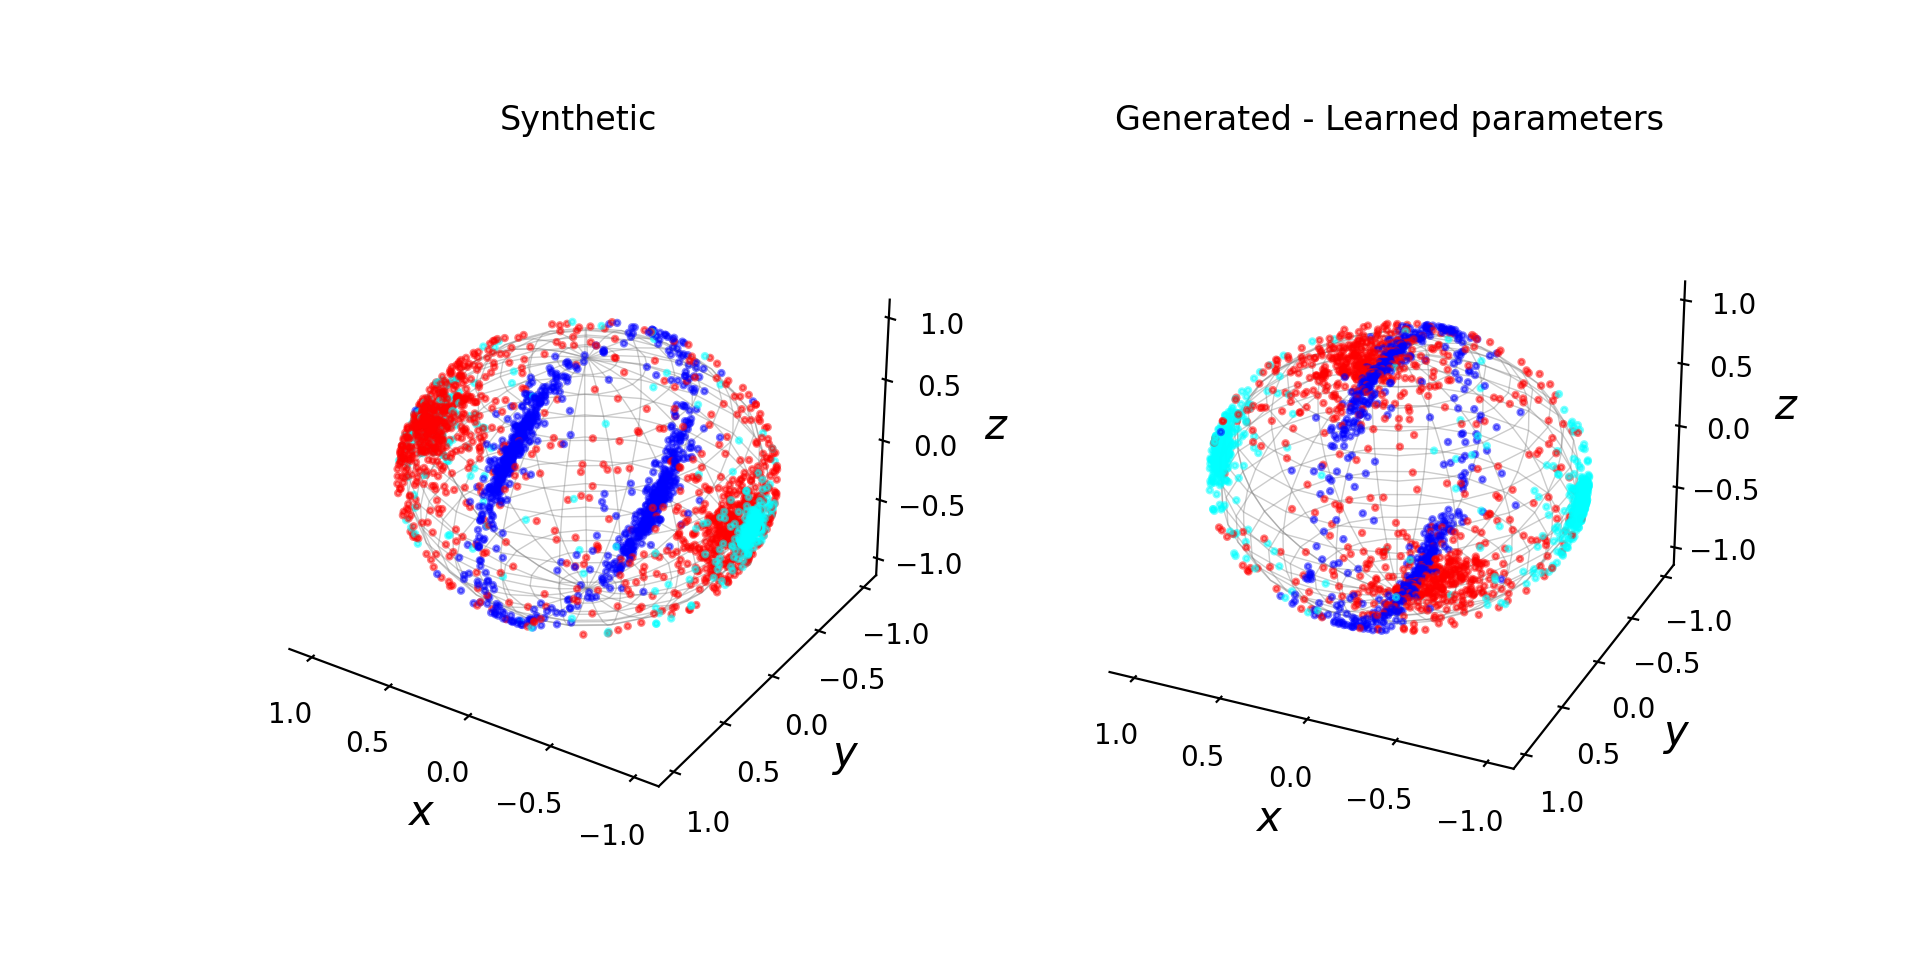

In [209]:
plt.close()
%matplotlib notebook

LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(0.5))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

X_gt_plot = torch.cat(tuple([*synX_emission]),0)
Z_seq_plot = torch.cat(tuple([*Z_seq]),0)


# Synthetic
ax = fig.add_subplot(1, 2, 1, projection='3d')
label_color = [id_2_color[id] for id in np.array(Z_seq_plot)]
ax.scatter(X_gt_plot[:, 0], X_gt_plot[:, 1], X_gt_plot[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Synthetic')

#Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)

# Learned
ax = fig.add_subplot(1, 2, 2, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)
plt.show()

# Viterbi decode - Angular Central Gaussian - HMM

In [235]:
# 0 -> 2
# 1 -> 1
# 2 -> 0
d = {'0':2,'2':0}

In [236]:
best_paths, paths_probs = best_model.viterbi2(synX_emission)

<IPython.core.display.Javascript object>


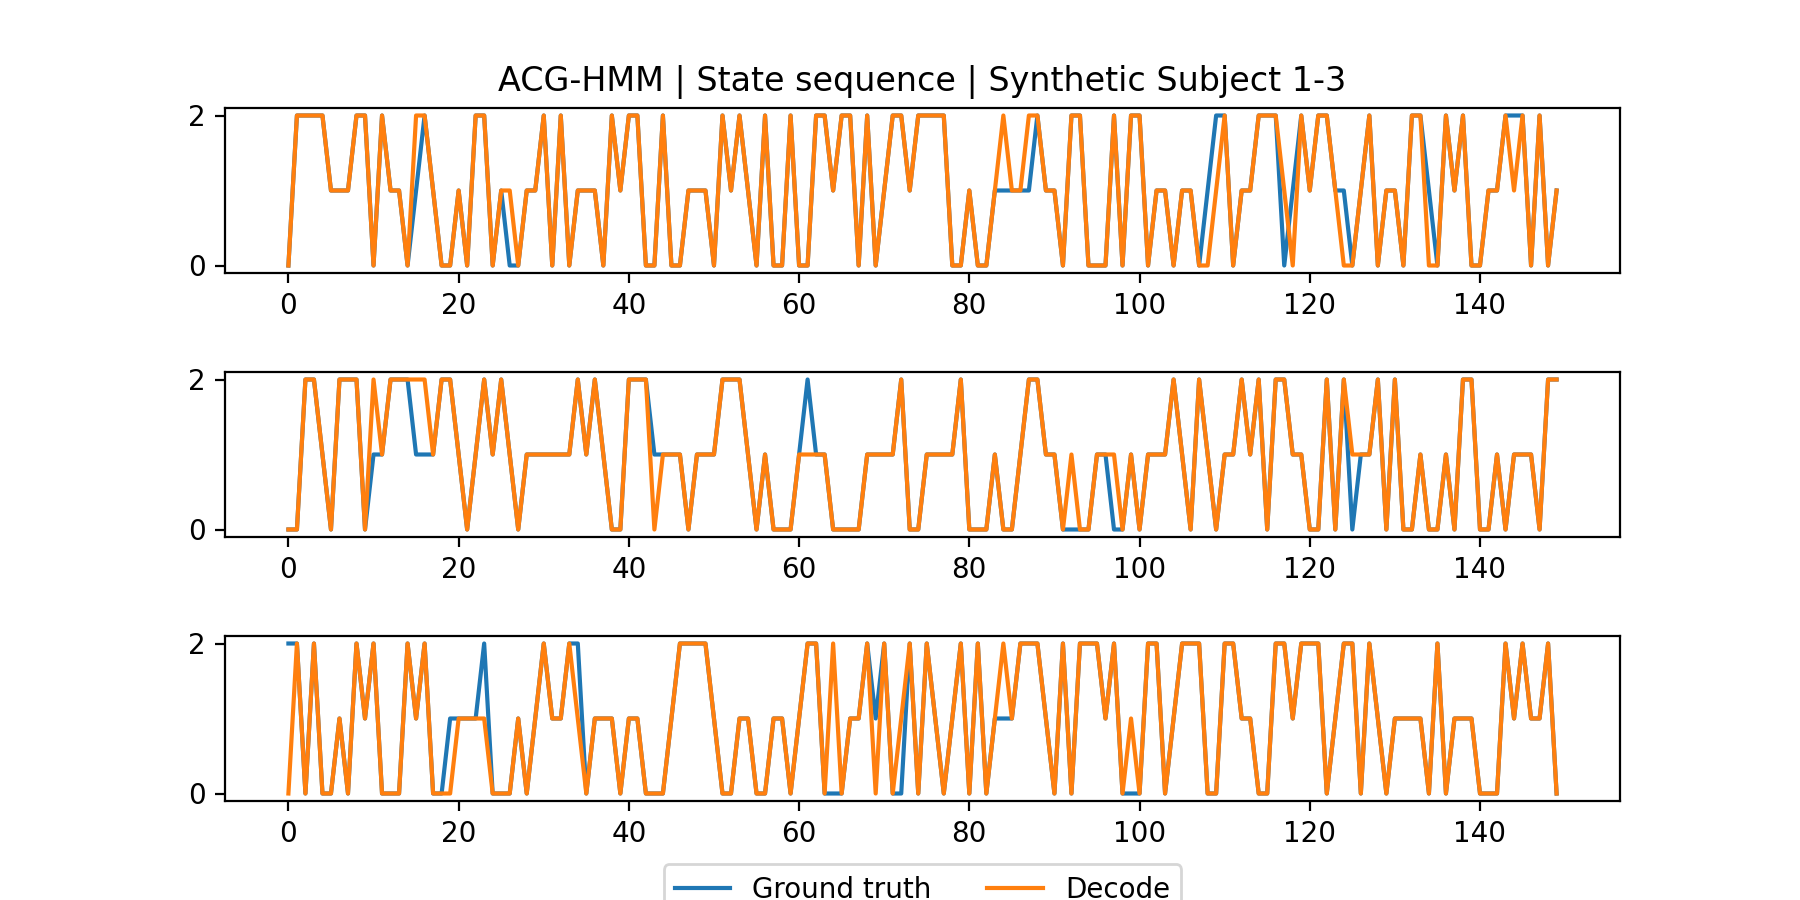

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [237]:
# sub = 4
# decode_path = list(best_paths[sub])
# decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
# decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(3,1, figsize=(9,4.5))
fig.subplots_adjust(hspace=0.6)

for sub in range(3):
    decode_path = list(best_paths[sub])
    #decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    ax[sub].plot(Z_seq[sub], label='Ground truth')
    ax[sub].plot(decode_path[:-1], label='Decode')
    ax[0].set_title('ACG-HMM | State sequence | Synthetic Subject 1-3')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
               ncol=2)

plt.show()

## ACG - HMM | NMI score

<IPython.core.display.Javascript object>


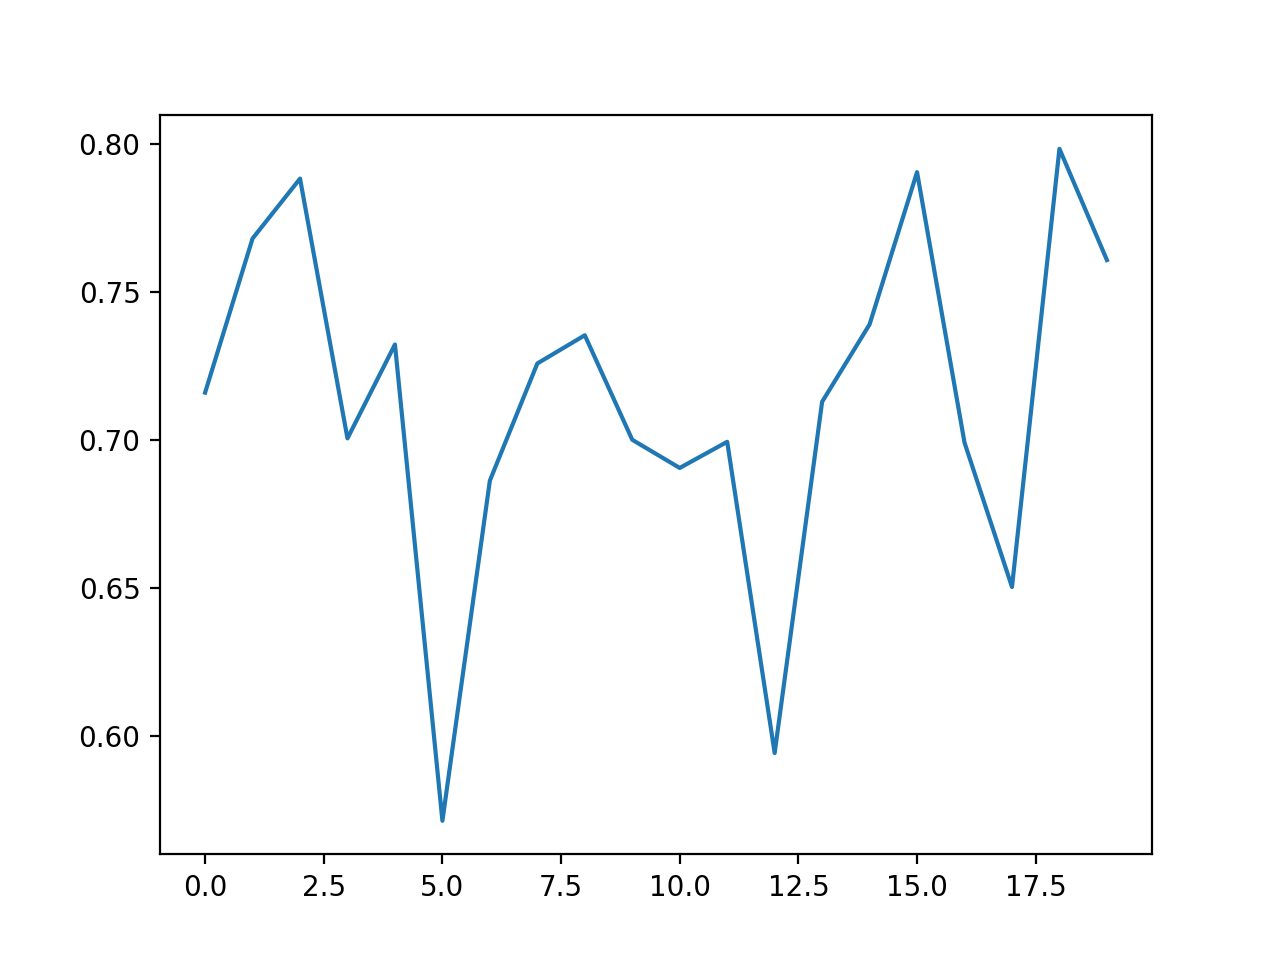

Average Watson NMI: 0.7129243313796799


In [238]:
d = {'0':2,'2':0} 
running_NMI = []
for sub in range(len(best_paths)):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    
    gt = Z_seq[sub]
    
    sub_NMI = NMI(gt,decode_path[:-1])
    running_NMI.append(sub_NMI)
plt.close()
plt.plot(running_NMI)
plt.show()
print(f'Average Watson NMI: {np.mean(running_NMI)}')